In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(spines=False,grid=True)

# Solver

In [2]:
NodesCondition = []
ForcesCondition = []

def UBoundaryCondition(nU,u,i):
    nU[i][0] = u
    NodesCondition.append(i)

def FBoundaryCondition(nF,f,i):
    nF[i][0] = f
    ForcesCondition.append(i)
    
def AssemblyStiffness(nStiffnessMatrix,k,i,j):
    nStiffnessMatrix[i][i] += k
    nStiffnessMatrix[i][j] += -k
    nStiffnessMatrix[j][i] += -k
    nStiffnessMatrix[j][j] += k

def Initialize(nStiffnessMatrix,nU,nF):
    for i in range(0,Nodes):
        nU[i][0] = math.pi
        nF[i][0] = math.pi
    for i in range(0,NumberOfElement):
        AssemblyStiffness(nStiffnessMatrix,K[i][0],int(K[i][1]),int(K[i][2]))

def PreSolvingStiffness(nStiffnessMatrix):
    nsize = Nodes-len(NodesCondition)
    newStiffness = np.zeros((nsize,nsize))
    contr = -1
    for i in range(0,Nodes):
        contc = -1
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        for j in range(0,Nodes):
            flagc = False
            for k in range(0,len(NodesCondition)):
                if(j == NodesCondition[k]):
                    flagc = True
                    break
            if(flagc):
                continue
            contc += 1
            newStiffness[contr][contc] = nStiffnessMatrix[i][j]
    return newStiffness


def PreSolvingF(nF,nS,nU):
    nsize = Nodes-len(NodesCondition)
    newF = np.zeros(nsize).reshape(nsize,1)
    contr = -1
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            for k in range(0,Nodes):
                nF[k][0] = nF[k][0]-nS[k][i]*nU[i][0]
            continue

            
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        newF[contr][0] = nF[i][0]
    
    return newF
                      

def Solve(nStiffnessMatrix,nU,nF):
    newStiffness = PreSolvingStiffness(nStiffnessMatrix)
    newF = PreSolvingF(nF,nStiffnessMatrix,nU)
    u = np.linalg.solve(newStiffness,newF)  
    contr = -1
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        nU[i][0] = u[contr][0]
    nnF = np.matmul(StiffnessMatrix,nU)
    return nU,nnF

# Defining the problem

In [3]:
NodesCondition = []
Nodes = 20
Nodes = 2*Nodes+1
E = 2*1e5 #MPA
L = 1500 #mm
b0 = 1000 #mm
bf = 0 #mm
e = 120 #mm
P = 50000 #N
K = []
y = 0.0784532e-3 #N/mm3
A = []

for i in range(0,Nodes):
    b = b0-i*((b0-bf)/(Nodes-1))
    nb = b0-(i+1)*(b0-bf)/(Nodes-1)
    A.append((b+nb)*e/2)
for i in range(0,Nodes-1):
    K.append([E*A[i]/(L/(Nodes-1)),i,i+1])

NumberOfElement = len(K)

StiffnessMatrix = np.zeros((Nodes,Nodes))
U = np.zeros(Nodes).reshape(Nodes,1)
F = np.zeros(Nodes).reshape(Nodes,1)

Initialize(StiffnessMatrix,U,F)
UBoundaryCondition(U,0,0)


for i in range(1,Nodes):
    if(i%2 == 1):
        W = y*(A[i]+A[i-1])*(L/(Nodes-1))
        FBoundaryCondition(F,W,i)
    else:
        FBoundaryCondition(F,0,i)
        
if((NumberOfElement//2)%2 == 1):
    W = y*(A[NumberOfElement//2]+A[NumberOfElement//2-1])*(L/(Nodes-1))
    FBoundaryCondition(F,P+W,NumberOfElement//2)
else:
    FBoundaryCondition(F,P,NumberOfElement//2)

U,F=Solve(StiffnessMatrix,U,F)


#print("Stiffness Matrix:\n",StiffnessMatrix,'\n')
#print("Displacements:\n",U,'\n')
#print("Forces:\n",F[0])

# Visualizing the data

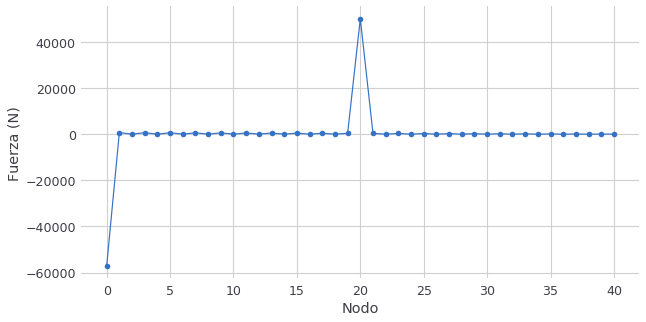

In [4]:
plt.figure(figsize=(10,5))
plt.xlabel("Nodo")
plt.ylabel("Fuerza (N)")
plt.plot(F,'-bo')
#plt.show()
#plt.savefig("forze20.pdf")

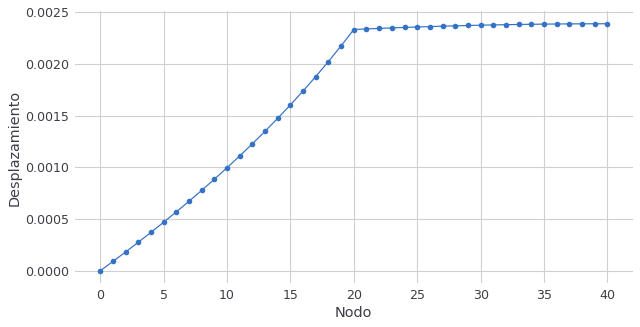

In [5]:
plt.figure(figsize=(10,5))
plt.xlabel("Nodo")
plt.ylabel("Desplazamiento")
plt.plot(U,'-ob')
#plt.show()
#plt.savefig("def30.pdf")

In [6]:
Displacements_data =  pd.DataFrame(data=U, columns=["Desplazamientos"])
Forces_data = pd.DataFrame(data=F, columns=["Fuerzas"])
Displacements_data.join(Forces_data)

,Desplazamientos,Fuerzas
0,0.000000,-5.706079e+04
1,0.000090,6.884268e+02
2,0.000182,1.455192e-11
3,0.000276,6.531229e+02
4,0.000371,-2.910383e-11
5,0.000469,6.178189e+02
6,0.000569,2.910383e-11
7,0.000672,5.825150e+02
8,0.000777,-1.164153e-10
9,0.000885,5.472111e+02


In [7]:
nU = []
nE = []
nstrain = []
sigma = []
strain = []
defor = []

dL = (b0-bf)/(Nodes-1)

for i in range(0,len(U)-1):
    strain.append(-U[i][0]/(dL)+U[i+1][0]/(dL))
    defor.append(strain[i]*dL)
    sigma.append(strain[i]*E)

print("Esfuerzos (MPa):\n",np.array(sigma).reshape((Nodes-1,1)))

Esfuerzos (MPa):
 [[ 7.22288456e-01]
 [ 7.32108587e-01]
 [ 7.51631482e-01]
 [ 7.63277237e-01]
 [ 7.84778004e-01]
 [ 7.98571295e-01]
 [ 8.22409244e-01]
 [ 8.38752374e-01]
 [ 8.65379434e-01]
 [ 8.84781857e-01]
 [ 9.14774462e-01]
 [ 9.37890985e-01]
 [ 9.71996111e-01]
 [ 9.99682697e-01]
 [ 1.03888594e+00]
 [ 1.07228334e+00]
 [ 1.11791242e+00]
 [ 1.15857530e+00]
 [ 1.21246252e+00]
 [ 1.26256578e+00]
 [ 4.52614615e-02]
 [ 3.86435019e-02]
 [ 4.08517020e-02]
 [ 3.42341236e-02]
 [ 3.64427768e-02]
 [ 2.98257424e-02]
 [ 3.20350567e-02]
 [ 2.54188368e-02]
 [ 2.76291704e-02]
 [ 2.10142500e-02]
 [ 2.32262763e-02]
 [ 1.66136188e-02]
 [ 1.88287680e-02]
 [ 1.22205946e-02]
 [ 1.44425209e-02]
 [ 7.84532000e-03]
 [ 1.00868400e-02]
 [ 3.53039400e-03]
 [ 5.88399000e-03]
 [-5.42101086e-15]]


In [8]:
heatmap = np.zeros((Nodes-1,Nodes-1))
for i in range(0,Nodes-1):
    for j in range(0,Nodes-1):
        if(2*j>=i-1 and 2*(Nodes-1)-2*j-1 >= i):
            heatmap[i][j] = 1e3*sigma[i]
        else:
            heatmap[i][j] = -6e1

/home/heneos/anaconda3/envs/HeNeosCPU/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


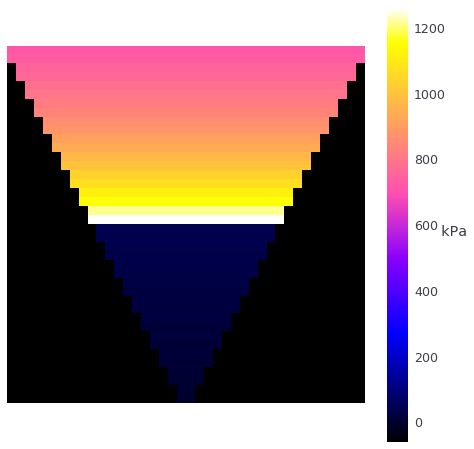

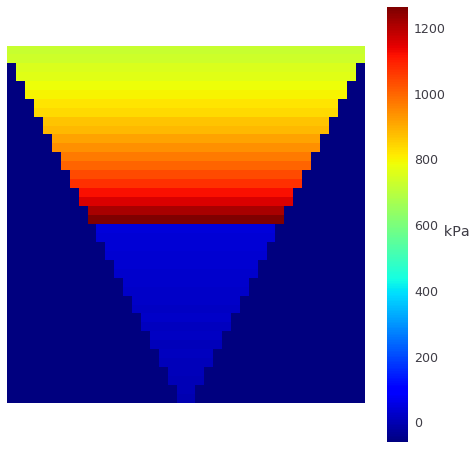

In [9]:
plt.figure(figsize=(8,8))
plt.grid(False)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
plt.imshow(heatmap,cmap='gnuplot2',interpolation='nearest')
plt.colorbar().set_label('  kPa',rotation=0)
#plt.savefig("21.pdf")
#plt.show()

plt.figure(figsize=(8,8))
plt.grid(False)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
plt.imshow(heatmap,cmap='jet',interpolation='nearest')
plt.colorbar().set_label('   kPa',rotation=0)
#plt.savefig("21.pdf")
#plt.show()


In [10]:
hdefor = np.zeros((U.shape[0]-1,U.shape[0]-1))
for i in range(0,U.shape[0]-1):
    for j in range(0,U.shape[0]-1):
        if(2*j>=i-1 and 2*U.shape[0]-2*j-1-2 >= i):
            hdefor[i][j] = U[i][0]
        else:
            hdefor[i][j] = 0

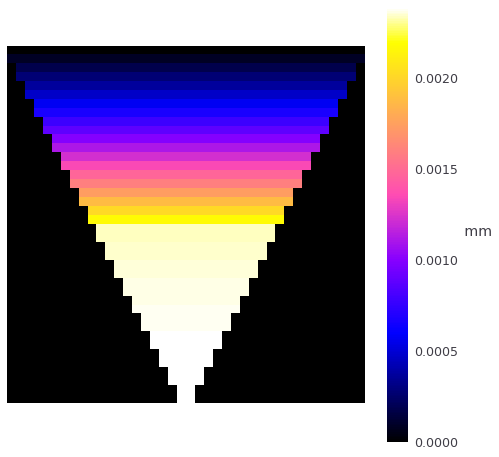

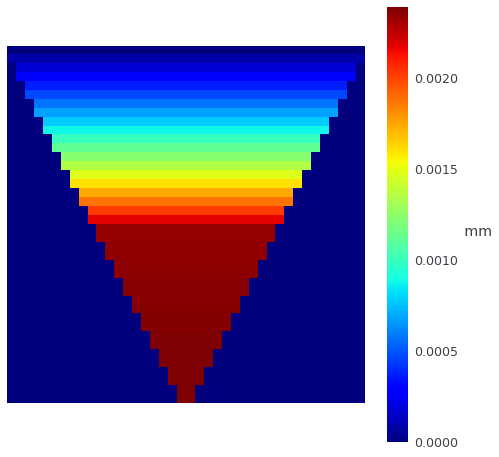

In [11]:
plt.figure(figsize=(8,8))
plt.grid(False)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
plt.imshow(hdefor,cmap='gnuplot2',interpolation='nearest')
plt.colorbar().set_label('       mm',rotation=0)
#plt.savefig("22.pdf")
#plt.show()

plt.figure(figsize=(8,8))
plt.grid(False)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
plt.imshow(hdefor,cmap='jet',interpolation='nearest')
plt.colorbar().set_label('       mm',rotation=0)
#plt.savefig("gg.pdf")
#plt.show()
